# Tutorial #1 - Preprocessing, Calibration, Augmentation, and Deconvolution

## Load the PyEEM library and display version

In [1]:
import pyeem
print(pyeem.__version__)

0.1.0


## Check out the supported instruments

In [2]:
pyeem.instruments.supported

name
manufacturer supported_models              
Agilent      Cary 4E                cary_4e
             Cary Eclipse      cary_eclipse
Horiba       Aqualog-880-C          aqualog
             SPEX Fluorolog-3     fluorolog

## Check out the demo datasets

In [3]:
demos_df = pyeem.datasets.demos
display(demos_df)

print("Dataset description for the Rutherford et al. demo:")
print(demos_df[
    demos_df["demo_name"] == "rutherford"
]["description"].item())

,demo_name,description,citation,DOI,absorbance_instrument,water_raman_instrument,EEM_instrument
0,rutherford,Excitation Emission Matrix (EEM) fluorescence ...,"Rutherford, Jay W., et al. ""Excitation emissio...",10.1016/j.atmosenv.2019.117065,Aqualog,None,Aqualog
1,drEEM,The demo dataset contains measurements made du...,"Murphy, Kathleen R., et al. ""Fluorescence spec...",10.1039/c3ay41160e,Cary 4E,Fluorolog,Fluorolog


Dataset description for the Rutherford et al. demo:
Excitation Emission Matrix (EEM) fluorescence spectra used for combustion generated particulate matter source identification using a neural network.


## Download the Rutherford et al. demo dataset from S3
- Please note that this step requires an internet connection because the data is downloaded from an AWS S3 bucket.

In [4]:
demo_data_dir = pyeem.datasets.download_demo(
    "demo_data",
    demo_name="rutherford"
)

Download Demo Dataset from S3: 239it [00:00, 284.89it/s]


## Load the dataset

In [5]:
calibration_sources = {
    "cigarette": "ug/ml",
    "diesel": "ug/ml",
    "wood_smoke": "ug/ml"
}
dataset = pyeem.datasets.Dataset(
    data_dir=demo_data_dir,
    raman_instrument=None,
    absorbance_instrument="aqualog",
    eem_instrument="aqualog",
    calibration_sources=calibration_sources,
)

## Let's checkout the metadata
- The metadata contains information about collected sample sets which are composed of a few different scan types.

In [6]:
display(dataset.meta_df.head())

datetime_utc         filename collected_by  \
sample_set scan_type                                                      
1          blank_eem  2020-07-01 10:29:05   blank_eem1.csv           JR   
           sample_eem 2020-07-01 10:29:06  sample_eem1.csv           JR   
           sample_eem 2020-07-01 10:29:07  sample_eem2.csv           JR   
           sample_eem 2020-07-01 10:29:08  sample_eem3.csv           JR   
           sample_eem 2020-07-01 10:29:09  sample_eem4.csv           JR   

                                             description  \
sample_set scan_type                                       
1          blank_eem            Spectroscopy Grade Blank   
           sample_eem                            Diesel1   
           sample_eem                            Diesel2   
           sample_eem                            Diesel3   
           sample_eem  Cigarette from Cookstove Lab Hood   

                                                                comments  \
sample_set scan_type                                                       
1          blank_eem   Raman units collected with 1 pixel binning so ...   
           sample_eem  Raman units collected with 1 pixel binning so ...   
           sample_eem  Raman units collected with 1 pixel binning so ...   
           sample_eem  Raman units collected with 1 pixel binning so ...   
           sample_eem  Raman units collected with 1 pixel binning so ...   

                       dilution  Raman_Area  cigarette  diesel  wood_smoke  \
sample_set scan_type                                                         
1          blank_eem        1.0   2040.3794       0.00     0.0         0.0   
           sample_eem       1.0   2040.3794       0.00     5.0         0.0   
           sample_eem       1.0   2040.3794       0.00     5.0         0.0   
           sample_eem       1.0   2040.3794       0.00     5.0         0.0   
           sample_eem       1.0   2040.3794       0.77     0.0         0.0   

                       calibration_sample  prototypical_sample  test_sample  \
sample_set scan_type                                                          
1          blank_eem                False                False        False   
           sample_eem                True                False         True   
           sample_eem                True                 True        False   
           sample_eem                True                False         True   
           sample_eem                True                False         True   

                      original_date  \
sample_set scan_type                  
1          blank_eem     2016-11-30   
           sample_eem    2016-11-30   
           sample_eem    2016-11-30   
           sample_eem    2016-11-30   
           sample_eem    2016-11-30   

                                                                filepath  \
sample_set scan_type                                                       
1          blank_eem   /home/roboat/Documents/roboat/PyEEM/examples/d...   
           sample_eem  /home/roboat/Documents/roboat/PyEEM/examples/d...   
           sample_eem  /home/roboat/Documents/roboat/PyEEM/examples/d...   
           sample_eem  /home/roboat/Documents/roboat/PyEEM/examples/d...   
           sample_eem  /home/roboat/Documents/roboat/PyEEM/examples/d...   

                              name                       hdf_path  
sample_set scan_type                                               
1          blank_eem    blank_eem1   raw_sample_sets/1/blank_eem1  
           sample_eem  sample_eem1  raw_sample_sets/1/sample_eem1  
           sample_eem  sample_eem2  raw_sample_sets/1/sample_eem2  
           sample_eem  sample_eem3  raw_sample_sets/1/sample_eem3  
           sample_eem  sample_eem4  raw_sample_sets/1/sample_eem4

## Checkout the metadata summary information

In [7]:
dataset.metadata_summary_info()

,Date Range,Number of Sample Sets,Number of blank EEMs,Number of sample EEMs,Number of water raman scans,Number of absorbance scans
0,"(Timestamp('2020-07-01 10:29:05'), Timestamp('...",14,20,107,0,107


## Create a preprocessing routine
- The demo dataset contains raw scans, in order to analyze and interpret this data, we must first apply several preprocessing steps.

In [8]:
routine_df = pyeem.preprocessing.create_routine(
    crop = True,
    discrete_wavelengths = False,
    gaussian_smoothing = False,
    blank_subtraction = True,
    inner_filter_effect = True,
    raman_normalization = True,
    scatter_removal = True,
    dilution = False,
)

display(routine_df)

,step_name,hdf_path
step_order,,
0,raw,raw_sample_sets/
1,crop,preprocessing/filters/crop
2,blank_subtraction,preprocessing/corrections/blank_subtraction
3,inner_filter_effect,preprocessing/corrections/inner_filter_effect
4,raman_normalization,preprocessing/corrections/raman_normalization
5,scatter_removal,preprocessing/corrections/scatter_removal
6,complete,preprocessing/complete/


## Execute the preprocessing routine
- Each preprocessing step has certain knobs and dials you can tune to have them run to your liking. It is worth checking the documentation to learn more about these customizations.
- Please note that depending on the steps and settings you've chosen as well as your dataset's size, the time it takes for this step to complete will vary.

In [9]:
crop_dimensions = {
    "emission_bounds": (246, 573),
    "excitation_bounds": (224, float("inf"))
}
routine_results_df = pyeem.preprocessing.perform_routine(
    dataset,
    routine_df,
    crop_dims=crop_dimensions,
    raman_source_type = "metadata",
    fill="interp",
    progress_bar=True
)

display(routine_results_df)

Preprocessing scan sets: 100%|██████████| 14/14 [01:34<00:00,  6.74s/it]


step_completed  \
sample_set scan_type  name        step_name                            
1          blank_eem  blank_eem1  raw                           True   
                                  crop                          True   
           sample_eem sample_eem1 raw                           True   
                                  crop                          True   
                                  blank_subtraction             True   
...                                                              ...   
16         sample_eem sample_eem1 raman_normalization           True   
                                  scatter_removal               True   
                                  complete                      True   
17         blank_eem  blank_eem1  raw                           True   
                                  crop                          True   

                                                      step_exception  \
sample_set scan_type  name        step_name                            
1          blank_eem  blank_eem1  raw                           None   
                                  crop                          None   
           sample_eem sample_eem1 raw                           None   
                                  crop                          None   
                                  blank_subtraction             None   
...                                                              ...   
16         sample_eem sample_eem1 raman_normalization           None   
                                  scatter_removal               None   
                                  complete                      None   
17         blank_eem  blank_eem1  raw                           None   
                                  crop                          None   

                                                                                                hdf_path  \
sample_set scan_type  name        step_name                                                                
1          blank_eem  blank_eem1  raw                                       raw_sample_sets/1/blank_eem1   
                                  crop                           preprocessing/filters/crop/1/blank_eem1   
           sample_eem sample_eem1 raw                                      raw_sample_sets/1/sample_eem1   
                                  crop                          preprocessing/filters/crop/1/sample_eem1   
                                  blank_subtraction    preprocessing/corrections/blank_subtraction/1/...   
...                                                                                                  ...   
16         sample_eem sample_eem1 raman_normalization  preprocessing/corrections/raman_normalization/...   
                                  scatter_removal      preprocessing/corrections/scatter_removal/16/s...   
                                  complete                         preprocessing/complete/16/sample_eem1   
17         blank_eem  blank_eem1  raw                                      raw_sample_sets/17/blank_eem1   
                                  crop                          preprocessing/filters/crop/17/blank_eem1   

                                                               units  
sample_set scan_type  name        step_name                           
1          blank_eem  blank_eem1  raw                  Intensity, AU  
                                  crop                 Intensity, AU  
           sample_eem sample_eem1 raw                  Intensity, AU  
                                  crop                 Intensity, AU  
                                  blank_subtraction    Intensity, AU  
...                                                              ...  
16         sample_eem sample_eem1 raman_normalization  Intensity, RU  
                                  scatter_removal      Intensity, RU  
                                  complete             Intensity,

## Check to see if any of the steps failed to complete
- If you are using a demo dataset, you should see an empty dataframe.

In [10]:
display(routine_results_df[
    routine_results_df["step_exception"].notna()
])

,,,,step_completed,step_exception,hdf_path,units
sample_set,scan_type,name,step_name,,,,


## Visualize the preprocessing steps for a single sample

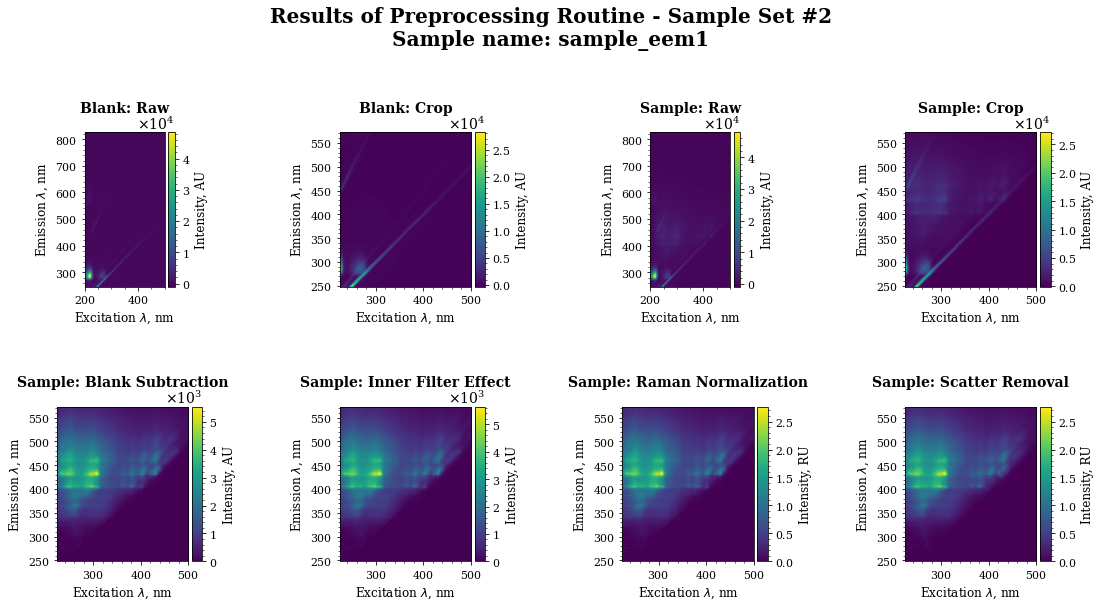

In [14]:
import matplotlib.pyplot as plt

sample_set = 2
sample_name = "sample_eem1"
axes = pyeem.plots.plot_preprocessing(
    dataset,
    routine_results_df,
    sample_set=sample_set,
    sample_name=sample_name,
    plot_type="imshow",
)
plt.show()

## Load the calibration information

In [15]:
cal_df = pyeem.preprocessing.calibration(
    dataset,
    routine_results_df
)
display(cal_df)

concentration  \
source     source_units intensity_units measurement_units        slope       intercept    r_squared                  
cigarette  ug/ml        Intensity, RU   Integrated Intensity, RU 2532.409217 -620.162018  0.929928            0.77   
                                                                                          0.929928            5.00   
                                                                                          0.929928            5.00   
                                                                                          0.929928            5.00   
                                                                                          0.929928            5.00   
...                                                                                                            ...   
wood_smoke ug/ml        Intensity, RU   Integrated Intensity, RU 4860.709872 -1572.345781 0.460195            0.50   
                                                                                          0.460195            0.50   
                                                                                          0.460195            2.00   
                                                                                          0.460195            1.00   
                                                                                          0.460195            5.00   

                                                                                                     integrated_intensity  \
source     source_units intensity_units measurement_units        slope       intercept    r_squared                         
cigarette  ug/ml        Intensity, RU   Integrated Intensity, RU 2532.409217 -620.162018  0.929928            1605.582491   
                                                                                          0.929928           11369.642711   
                                                                                          0.929928            9937.219073   
                                                                                          0.929928           14786.022223   
                                                                                          0.929928           14005.964492   
...                                                                                                                   ...   
wood_smoke ug/ml        Intensity, RU   Integrated Intensity, RU 4860.709872 -1572.345781 0.460195            2654.533537   
                                                                                          0.460195             856.330949   
                                                                                          0.460195            3413.400549   
                                                                                          0.460195            1719.608567   
                                                                                          0.460195           23200.187472   

                                                                                                     prototypical_sample  \
source     source_units intensity_units measurement_units        slope       intercept    r_squared                        
cigarette  ug/ml        Intensity, RU   Integrated Intensity, RU 2532.409217 -620.162018  0.929928                 False   
                                                                                          0.929928                  True   
                                                                                          0.929928                  True   
                                                                                          0.929928                 False   
                                                                                          0.929928                 False   
...                                                                     

## Checkout the calibration summary information

In [16]:
cal_summary_df = pyeem.preprocessing.calibration_summary_info(cal_df)
display(cal_summary_df)

,source,source_units,intensity_units,measurement_units,slope,intercept,r_squared,Number of Samples,Min. Concentration,Max. Concentration
0,cigarette,ug/ml,"Intensity, RU","Integrated Intensity, RU",2532.409217,-620.162018,0.929928,26,0.2,5.0
1,cigarette,ug/ml,"Intensity, RU","Integrated Intensity, RU",2532.409217,-620.162018,0.929928,26,0.2,5.0
2,cigarette,ug/ml,"Intensity, RU","Integrated Intensity, RU",2532.409217,-620.162018,0.929928,26,0.2,5.0


## Plot the calibration curves

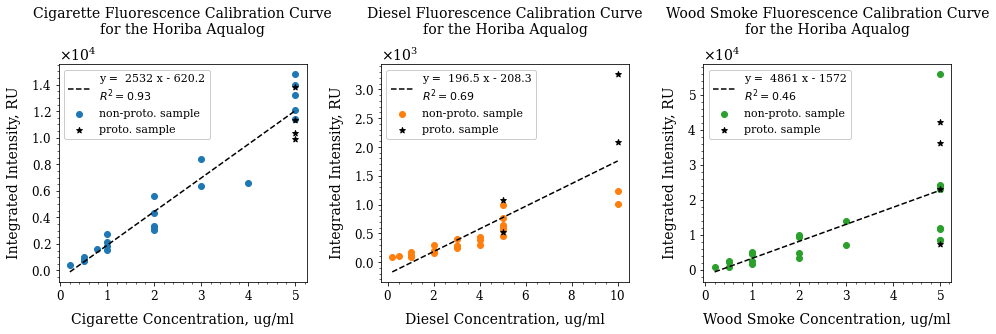

In [17]:
axes = pyeem.plots.plot_calibration_curves(dataset, cal_df)
plt.show()

## Create prototypical spectra and then plot them

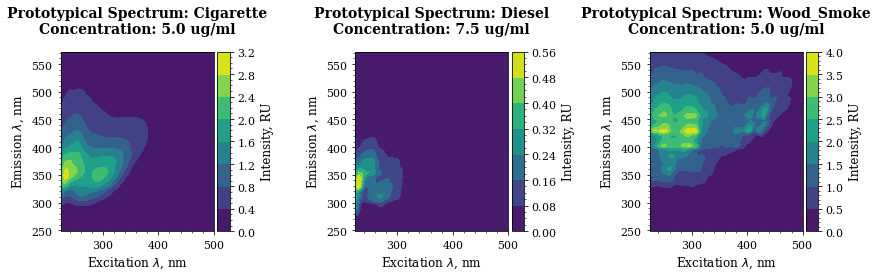

In [18]:
proto_results_df = pyeem.augmentation.create_prototypical_spectra(dataset, cal_df)
axes = pyeem.plots.plot_prototypical_spectra(
    dataset,
    proto_results_df,
    plot_type="contour"
)
plt.show()

## Augmented Spectra - Single Sources
### Create augmented single source spectra by scaling each prototypical spectrum across a range of concentrations

In [20]:
ss_results_df = pyeem.augmentation.create_single_source_spectra(
    dataset,
    cal_df,
    conc_range=(0, 5),
    num_spectra=10
)

100%|██████████| 3/3 [00:00<00:00,  5.95it/s]


## Plot the augmented single source spectra

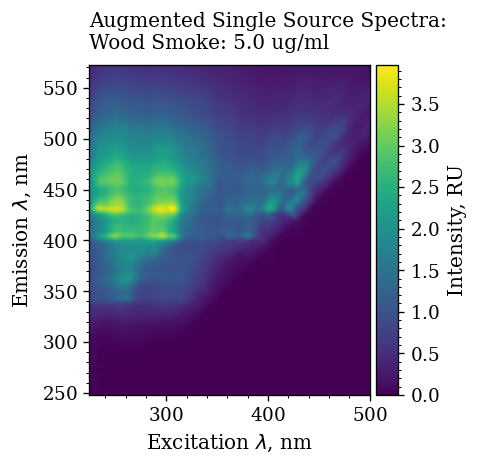

In [35]:
from IPython.display import HTML
%matplotlib inline

source = "wood_smoke"
anim = pyeem.plots.single_source_animation(
    dataset,
    ss_results_df,
    source=source,
    plot_type="imshow",
    fig_kws={"dpi": 120},
    animate_kws={"interval": 100, "blit": True},
    surface_plot_kws={"rstride":10,"cstride":10}
)
HTML(anim.to_html5_video())

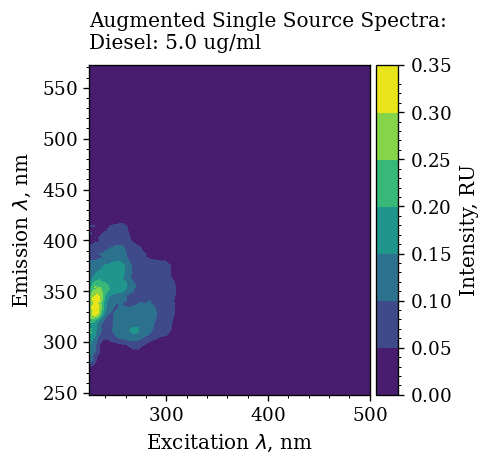

In [27]:
source = "diesel"
anim = pyeem.plots.single_source_animation(
    dataset,
    ss_results_df,
    source=source,
    plot_type="contour",
    fig_kws={"dpi": 120},
    animate_kws={"interval": 100, "blit": True},
)
HTML(anim.to_html5_video())

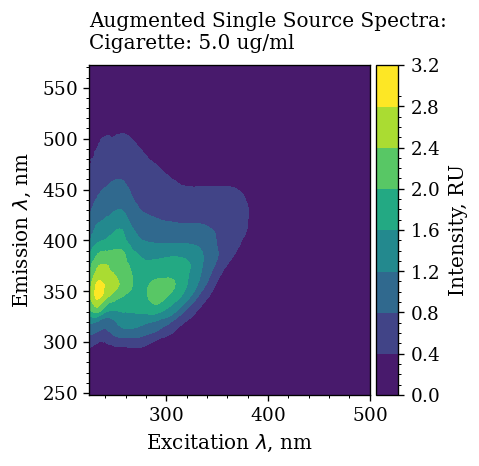

In [28]:
source = "cigarette"
anim = pyeem.plots.single_source_animation(
    dataset,
    ss_results_df,
    source=source,
    plot_type="contour",
    fig_kws={"dpi": 120},
    animate_kws={"interval": 100, "blit": True},
)
HTML(anim.to_html5_video())

## Augmented Spectra - Mixtures
### Create augmented mixture spectra by scaling and combining the prototypical spectra across a range of concentrations

In [29]:
mix_results_df = pyeem.augmentation.create_mixtures(
    dataset,
    cal_df,
    conc_range=(0.01, 6.3),
    num_steps=5
)

Creating Augmented Mixtures: 100%|██████████| 125/125 [00:02<00:00, 46.09it/s]


## Plot the augmented mixture spectra

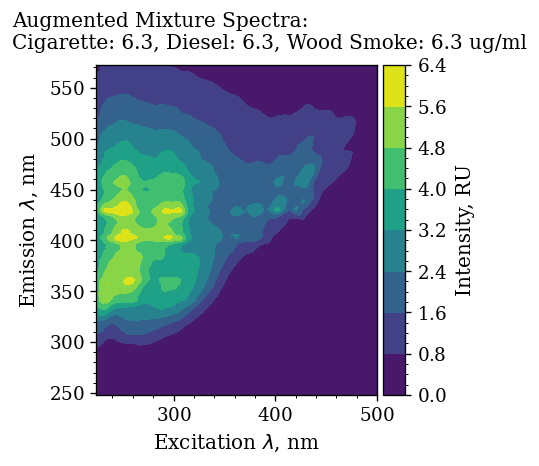

In [32]:
anim = pyeem.plots.mixture_animation(
    dataset,
    mix_results_df,
    plot_type="contour",
    fig_kws={"dpi": 120},
    animate_kws={"interval": 100, "blit": True},
    surface_plot_kws={"rstride":10,"cstride":10}
)
HTML(anim.to_html5_video())

In [36]:
rutherfordnet = pyeem.analysis.models.RutherfordNet()
rutherfordnet.model.summary()

Model: "rutherfordnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 142, 139, 20)      520       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 46, 20)        0         
_________________________________________________________________
dropout (Dropout)            (None, 47, 46, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 46, 10)        20010     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 10)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 10)      

In [37]:
(x_train, y_train), (x_test, y_test) = rutherfordnet.prepare_data(
    dataset,
    ss_results_df,
    mix_results_df,
    routine_results_df
)

history = rutherfordnet.train(x_train, y_train)

Epoch 1/5
3/3 [==============================] - 1s 357ms/step - loss: 3.6658 - accuracy: 0.4026 - val_loss: 8.0302 - val_accuracy: 0.1538
Epoch 2/5
3/3 [==============================] - 1s 292ms/step - loss: 2.3787 - accuracy: 0.6234 - val_loss: 8.3243 - val_accuracy: 0.2308
Epoch 3/5
3/3 [==============================] - 1s 292ms/step - loss: 2.2401 - accuracy: 0.6883 - val_loss: 8.8647 - val_accuracy: 0.1923
Epoch 4/5
3/3 [==============================] - 1s 291ms/step - loss: 2.1424 - accuracy: 0.6883 - val_loss: 6.4635 - val_accuracy: 0.2308
Epoch 5/5
3/3 [==============================] - 1s 304ms/step - loss: 1.7971 - accuracy: 0.6883 - val_loss: 7.7150 - val_accuracy: 0.2308


In [38]:
predictions = rutherfordnet.model.predict(x_train)